# TP4 : model-free RL 

Jusqu'à lors, nous avons étudié des cas où le modèle de la matrice de transition et de la récompense étaient modélisés : c'est le cadre du *model-based reinforcement learning*. 
Pour gérer des cas plus complexes, nous devons soulager ces hypothèses. Dans le *model-free reinforcement learning*, on regarde les expériences passées, échecs comme réussites, pour simuler le modèle sous-jacent.

Ce TP propose d'implémenter plusieurs algorithmes allant dans ce sens.


RAPPEL : 1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [149]:
! pip install numpy matplotlib 'gym[toy_text, classic_control]'
# Pour gérer les dépendances de PyGame: https://www.pygame.org/wiki/Compilation
# A cause de PyGame, la version de Python doit être inférieure à 3.10 !

Defaulting to user installation because normal site-packages is not writeable


In [150]:
%load_ext autoreload
%autoreload 2
import random
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import gym

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Présentation de Gym
Dans ce TP, nous allons utiliser le simulateur Gym par Open AI. Gym fournit une série d'environnements qui ont permis aux chercheurs de se comparer et ainsi, de faire accélérer la recherche en reinforcement learning.

In [151]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

env.reset()
for _ in range(10):
    env.render()
    env.step(env.action_space.sample()) # Take a random action
    
env.close()

**Q1. Décrire l'environnement Taxi. En particulier, vous vous demanderez quel est l'espace d'action ? Des états ? Comment est définie la récompense ? Que contient l'output de `env.step` ?**

La documentation de cet environnement est disponible ici:
    [https://www.gymlibrary.dev/api/core/#gym.Env.step](https://www.gymlibrary.dev/api/core/#gym.Env.step)

L'environnement Taxi est un parking avec plusieurs éléments. Il y a quatre emplacements désignés dans le monde de la grille indiqués par R (ed), G (reen), Y (ellow) et B (lue). Lorsque l'épisode commence, le taxi démarre sur une case aléatoire et le passager se trouve à un endroit aléatoire. Le taxi se rend à l'emplacement du passager, prend le passager, le conduit jusqu'à sa destination (un autre des quatre emplacements spécifiés), puis dépose le passager. Une fois le passager déposé, l'épisode se termine.

Il existe 6 actions déterministes discrètes :
* 0 : se déplacer vers le sud
* 1 : se déplacer vers le nord
* 2 : se déplacer vers l'est
* 3 : se déplacer vers l'ouest
* 4 : prendre un passager
* 5 : déposer un passager

L'output de `env.step` est un Tuple[ObsType, float, bool, bool, dict], il contient :

* observation (objet) - ce sera un élément de l'espace d'observation de l'environnement. Cela peut, par exemple, être un tableau numpy contenant les positions et les vitesses de certains objets.
* reward (float) - Le montant de la récompense retournée à la suite de l'action.
* terminated (bool) – si un état terminal est atteint. Dans ce cas, d'autres appels step() pourraient renvoyer des résultats indéfinis.
* truncated (bool) – Généralement une limite de temps, mais peut également être utilisée pour indiquer que l'agent sort physiquement des limites. Peut être utilisé pour mettre fin à l'épisode prématurément avant qu'un état terminal ne soit atteint.
* info (dict) - info contient des informations de diagnostic auxiliaires (utiles pour le débogage, l'apprentissage et la journalisation). Cela peut, par exemple, contenir : des métriques qui décrivent l'état de performance de l'agent, des variables qui sont masquées dans les observations ou des termes de récompense individuels qui sont combinés pour produire la récompense totale. Il peut également contenir des informations qui distinguent la troncature et la terminaison, mais cela est déconseillé en faveur du retour de deux booléens, et sera supprimé dans une future version.

## Q-Learning

Dans cette partie, nous allons utiliser le Q-Learning pour résoudre cette tâche.

mean reward -10.12


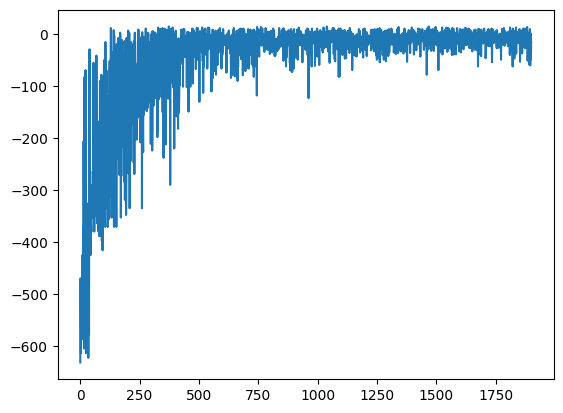

In [152]:
from qlearning import QLearningAgent

env = gym.make("Taxi-v3", render_mode="rgb_array")
n_actions = env.action_space.n

agent = QLearningAgent(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

def play_and_train(env: gym.core.Env, agent: QLearningAgent, t_max=int(1e4)) -> float:
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total rewardb
    """
    total_reward = 0.0
    s, info = env.reset()
    
    for t in range(t_max):
        # TODO get agent to pick action given state s
        a = agent.get_action(s)
        next_s, r, done, truncated, info = env.step(a)

        # TODO train agent for state s
        if not done:
            agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward += r
        if done or truncated:
            break
        
    return total_reward

rewards = []
for i in range(2000):
    rewards.append(play_and_train(env,agent))  
    if i % 100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

**Q2. Complétez les bouts manquants de code dans `qlearning.py` et dans la fonction `play_and_train`. Entrainez l'agent. Que se passe-t'il ? Regardez des exemples de trajectoire.**

On observe qu'au cours du temps, l'entrainement de l'agent lui permet d'adapter ses trajectoires et les récompenses obtenues se stabilisent autour de 0.  
Cependant, l'agent ne parvient pas à conserver des récompenses positives et la moyenne des récompenses obtenues reste négative.

## Réduire epsilon au-fur-et-à-mesure

Pour améliorer les performances, nous allons réduire $\epsilon$ au cours du temps.

La manière la plus simple consiste à réduire $\epsilon$ à chaque épisode, par exemple en le multipliant par un nombre proche de 1 (tel que 0.99) ou lui soustraire un pettit nombre. Vous pouvez, bien sûr, envisager d'autres stratégies !

**Q3. Améliorez l'algorithme dans `q_learning_eps_scheduling.py` de sorte à avoir une récompense positive**

mean reward 7.45


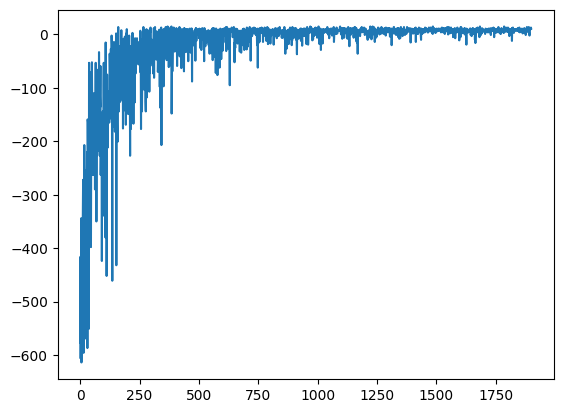

In [110]:
from qlearning_eps_scheduling import QLearningAgentEpsScheduling

agent = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.1,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

rewards = []
for i in range(2000):
    rewards.append(play_and_train(env,agent))    
    if i % 100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

En réduisant epsilon, on observe que l'agent parvient à conserver des récompenses positives et la moyenne des récompenses obtenues reste positive.

**Q4. Produisez quelques vidéos des trajectoires obtenus. Rassemblez des cas de réussite et des cas d'échecs**

## Espace d'action continu

Nous allons maintenant passer à un environnement plus difficile : le pendule inversé. C'est un grand classique des problèmes de contrôle !

Puisque l'environnement a un espace d'actions continu, nous allons discrétiser cet espace pour revenir aux cas précédemment étudiés.
La solution la plus simple pour cela consiste à diviser l'espace en sections égales. Mais comment choisir le nombre de sections ?

first state:  (array([-0.03810942,  0.02133057,  0.01372447,  0.02901864], dtype=float32), {})


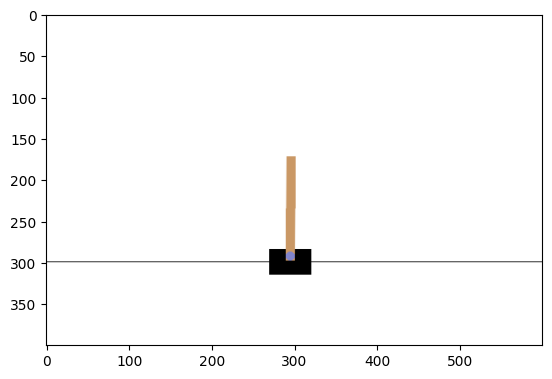

In [16]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
n_actions = env.action_space.n

print("first state: ", env.reset())
plt.imshow(env.render())
env.close()

**Q5. Décrivez cet environnement à l'aide de la documentation de Gym en reprenant la Q1.**

Cet environnement correspond à la version du problème du chariot décrit par Barto, Sutton et Anderson dans "Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem". Un poteau est attaché par une articulation non actionnée à un chariot, qui se déplace le long d'une piste sans frottement. Le pendule est placé debout sur le chariot et le but est d'équilibrer la perche en appliquant des forces dans la direction gauche et droite sur le chariot.

L'action est un array de forme (1,) qui peut prendre des valeurs {0, 1} indiquant la direction de la force fixe avec laquelle le chariot est poussé.
Remarque : La vitesse qui est réduite ou augmentée par la force appliquée n'est pas fixe et dépend de l'angle vers lequel pointe la perche. Le centre de gravité du poteau fait varier la quantité d'énergie nécessaire pour déplacer le chariot en dessous.

Puisque le but est de maintenir le poteau droit le plus longtemps possible, une récompense de +1 pour chaque pas effectué, y compris le pas de terminaison, est attribuée.

Pour mener à bien notre discrétisation de l'espace des actions, nous allons estimer la distribution des observations.

**Q6. Simulez 1000 épisodes et regardez la distribution des états à l'aide d'un histogramme. Quel paramètre vous paraît optimal pour choisir le nombre de `bins` ?**

/home/leme/.local/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


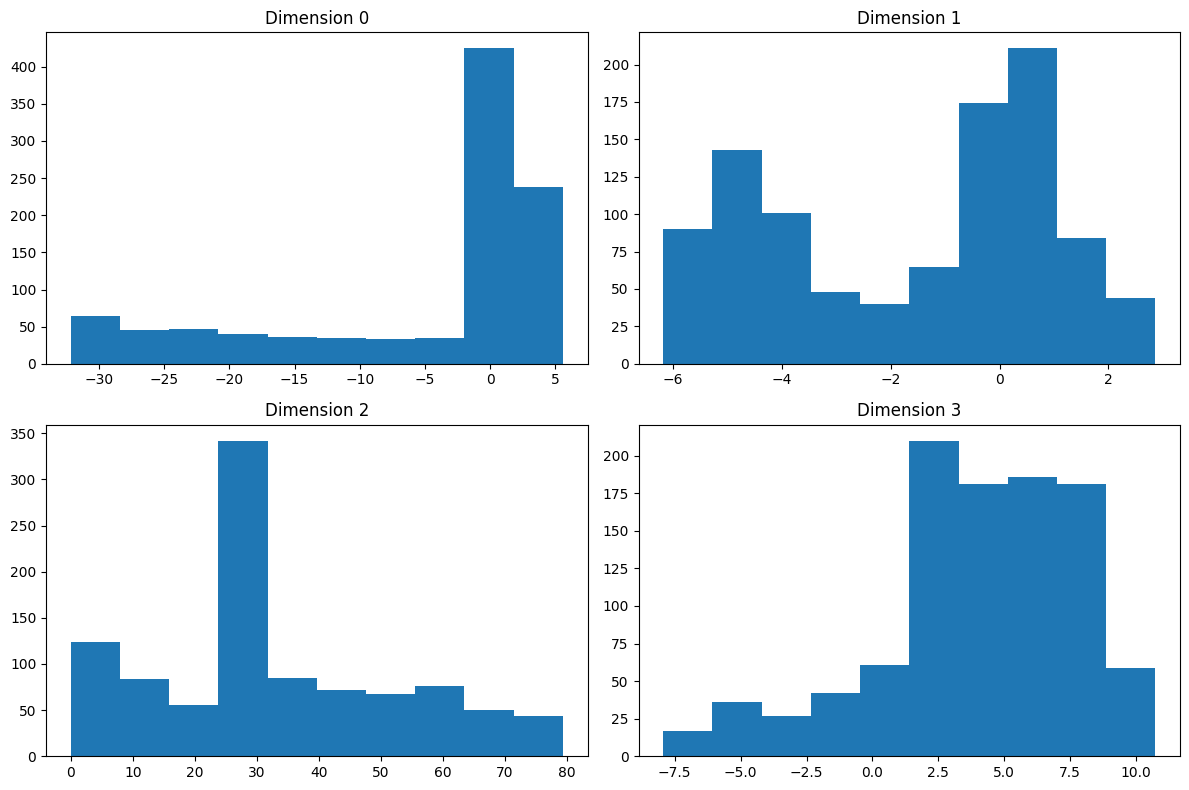

In [139]:
# Simulate 1000 steps and check the state distribution with a histogram
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

states = []
for _ in range(1000):
    states.append(env.step(env.action_space.sample())[0])

env.close()

# Plot the 4 dimensions of the state
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist([s[i] for s in states])
    plt.title("Dimension {}".format(i))
plt.tight_layout()

La dimension de l'espace d'observation est de 4:
- dimension 0: position du chariot
- dimension 1: vitesse du chariot
- dimension 2: angle du pendule
- dimension 3: vitesse du pendule

En simulant 1000 épisodes, on observe que la distribution des états est très concentrée autour de 0 pour les dimensions 0 et 1 et autour de $\pi$ pour les dimensions 2 et 3.

## Discrétiser l'environnement

In [144]:
from gym.core import ObservationWrapper
import math

class Binarizer(ObservationWrapper):
    def observation(self, state: np.ndarray) -> np.ndarray:  
        # TODO binarize each dimension of the state
        state[0] = np.digitize(state[0], bins=[]) #cart position
        state[1] = np.digitize(state[1], bins=[]) #cart velocity
        state[2] = np.digitize(state[2], bins=[-math.radians(6),-math.radians(1),0,math.radians(1),math.radians(6)]) #pole angle
        state[3] = np.digitize(state[3], bins=[-math.radians(50),math.radians(50)]) #pole velocity
        return state

bi_env = Binarizer(gym.make("CartPole-v0"))

**Q7. Complétez le code ci-dessus pour binariser l'environnement. Regardez la nouvelle distribution des états. Qu'en pensez-vous ?**

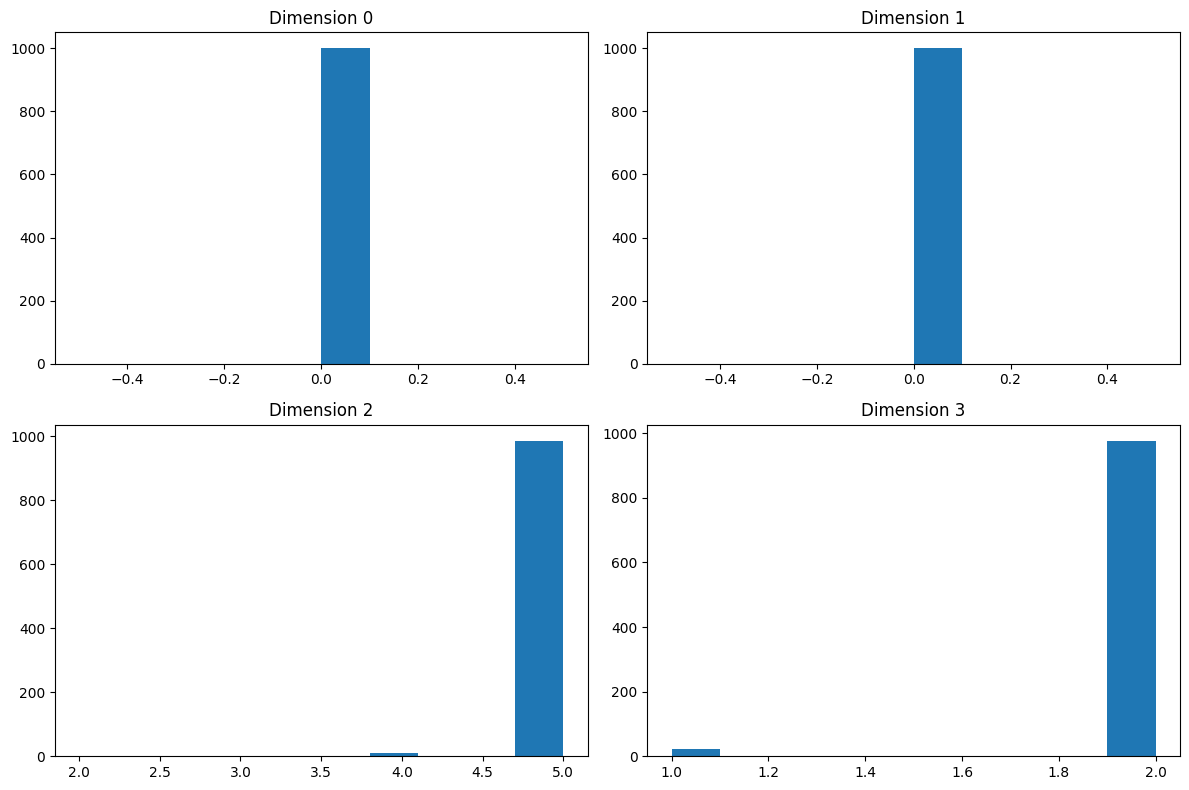

In [145]:
# Simulate 1000 steps and check the state distribution with a histogram
bi_env.reset()
bi_states = []
for _ in range(1000):
    bi_states.append(bi_env.step(bi_env.action_space.sample())[0])

bi_env.close()

# Plot the 4 dimensions of the state
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist([s[i] for s in bi_states])
    plt.title("Dimension {}".format(i))
plt.tight_layout()

On observe que la distribution des états est beaucoup plus concentrée autour de 0 pour les dimensions 0 et 1 et autour de $\pi$ pour les dimensions 2 et 3.

### Apprentissage sur l'environnement discretisé

**Q8. Reprenez votre agent pour résoudre cette tâche. Tracez la récompense et observez quelques trajectoires d'échecs et de réussites à l'aide de vidéos**

mean reward 199.88


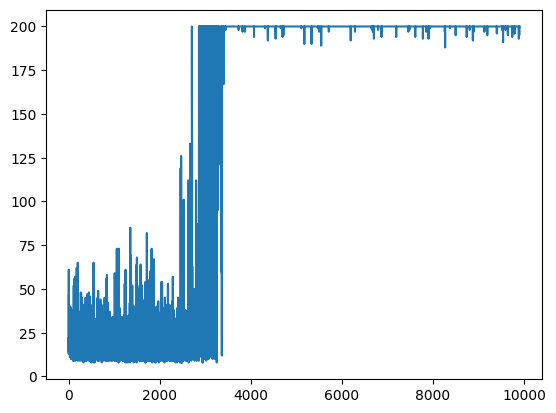

In [146]:
from qlearning_eps_scheduling import QLearningAgentEpsScheduling

bi_env = Binarizer(gym.make("CartPole-v0", render_mode="rgb_array"))
n_actions = bi_env.action_space.n

agent = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=1,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

def play_and_train(env: gym.core.Env, agent: QLearningAgentEpsScheduling, t_max=int(1e4)) -> float:
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total rewardb
    """
    total_reward = 0.0
    s, info = env.reset()
    
    for t in range(t_max):
        # TODO get agent to pick action given state s
        a = agent.get_action(tuple(s))
        
        next_s, r, done, truncated, info = env.step(a)

        # TODO train agent for state s
        if not done:
            agent.update(tuple(s), a, total_reward, tuple(next_s))
        
        s = next_s
        total_reward += r
        if done or truncated:
            break
    return total_reward

rewards = []
for i in range(10000):
    rewards.append(play_and_train(bi_env,agent))    
    if i % 100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

bi_env.close()

Après avoir ajuster les hyperparamètres (passage de espilon à 1) et les bins, on observe que l'agent arrive à converger vers des récompenses très positives, indiquant que l'agent a appris à résoudre le problème.

## 4. Experience replay 

Les algorithmes *off-policy* peuvent s'entraîner grâce à des trajectoires anciennement obtenues. Tirons parti de cette propriété pour 
améliorer l'efficacité de nos algorithmes et les permettre de converger plus rapidement.

L'idée générale est de collecter les tuplets `<s,a,r,s'>` dans un *buffer*, puis de mettre à jour la fonction Q sur l'ensemble de ces tuplets.
Plus en détails, voici l'algorithme à suivre

#### S'entraîner avec un *experience replay*
1. Echantillonner un tuplet `<s,a,r,s'>`.
2. Stocker ce tuplet dans un buffer FIFO : si le buffer est plein, on supprimer les données arrivées en premier.
3. Choisir aléatoirement K tuplets du buffer et mettre à jour la fonction Q sur ces tuplets.

**Q9. Implémentez un tel buffer**

In [147]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
            
        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._maxsize = size
        self._next_idx = 0
        self._storage = []
        self._n_transitions_stored = 0

    def __len__(self):
        return self._n_transitions_stored
    
    def add(self, s, a, r, next_s):
        """
        Add a new experience to memory.
        Parameters
        ----------
        s: np.ndarray
            Current state
        a: int
            Chosen action
        r: float
            Received reward
        next_s: np.ndarray
            Next state
        """
        if self._n_transitions_stored < self._maxsize:
            self._storage.append((s, a, r, next_s))
            self._n_transitions_stored += 1
        else:
            self._storage[self._next_idx] = (s, a, r, next_s)
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def sample(self, batch_size):
        """
        Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        states: np.ndarray
            array of states
        actions: np.ndarray
            array of actions executed given state
        rewards: np.ndarray
            rewards received for executing given actions
        next_states: np.ndarray
            next state yielded by executing given actions
        """
        # TODO sample batch_size many elements from self._storage
        idx = np.random.choice(len(self._storage), batch_size)
        return [self._storage[i] for i in idx]
    
    def clear(self):
        self._storage = []
        self._n_transitions_stored = 0

# Some tests to make sure your buffer works right

replay = ReplayBuffer(2)
obj1 = tuple(range(4))
obj2 = tuple(range(6, 10))
replay.add(*obj1)
assert replay.sample(1) == [obj1], "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."

list_a = []
for a in replay.sample(100):
    list_a.append(a)
uniqa = np.unique(list_a)
assert list(uniqa) == list(obj2)

replay.add(*obj1)
list_a = []
for a in replay.sample(100):
    list_a.append(a)
uniqa = np.unique(list_a)
assert len(uniqa) == 8 # 8 = 2 objects !

replay.add(*obj1)
list_a = []
for a in replay.sample(100):
    list_a.append(a)
uniqa = np.unique(list_a)
assert list(uniqa) == list(obj1)
print("Success!")

Success!


Maintenant utilisons ce replay buffer pour améliorer les performances d'entraînement.

**Q10. Entraînez un agent avec le replay buffer. Comparez l'évolution de la récompense sur l'environnement Taxi avec un algorithme n'utilisant pas le replay buffer.**

Pour rendre l'affichage plus visible, vous filterez la récompense avec un filtre de votre choix.

mean reward baseline 3.17
mean reward replay -220.97


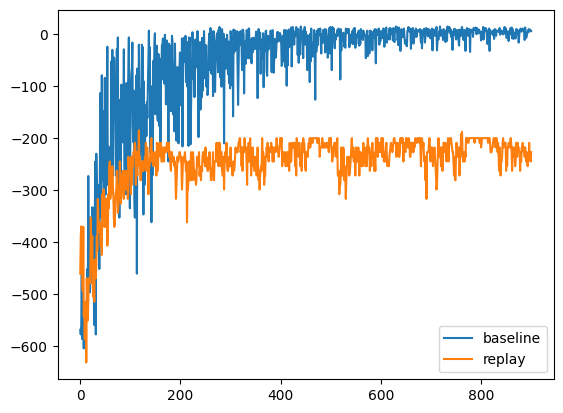

100%|██████████| 1000/1000 [01:37<00:00, 10.20it/s]


In [182]:
from qlearning_eps_scheduling import QLearningAgentEpsScheduling
import tqdm

agent_baseline = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

agent_replay = QLearningAgentEpsScheduling(
    learning_rate=0.5,
    epsilon=0.25,
    gamma=0.99,
    legal_actions=list(range(n_actions))
)

replay = ReplayBuffer(1000)

def play_and_train_replay(
    env: gym.core.Env, 
    agent: QLearningAgentEpsScheduling, 
    t_max: int = int(1e4),
    batch_size: int = 32,
) -> float:
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total rewardb
    """
    total_reward = 0.0
    s, info = env.reset()
    
    for t in range(t_max):
        # TODO get agent to pick action given state s
        a = agent.get_action(s)
        
        next_s, r, done, truncated, info = env.step(a)
        
        # TODO train agent for state s
        # ...
        if replay is not None:
            replay.add(s, a, r, next_s)
            if len(replay) > batch_size:
                batch = replay.sample(batch_size)
                for s, a, r, next_s in batch:
                    agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward += r
        if done or truncated:
            break
        
    return total_reward

rewards_baseline = []
rewards_replay = []
for i in tqdm.tqdm(range(1000)):
    rewards_baseline.append(play_and_train(env, agent_baseline))
    rewards_replay.append(play_and_train_replay(env, agent_replay))

    if i % 100 == 0:
        clear_output(True)
        print("mean reward baseline", np.mean(rewards_baseline[-100:]))
        print("mean reward replay", np.mean(rewards_replay[-100:]))
        plt.plot(rewards_baseline, label='baseline')
        plt.plot(rewards_replay, label='replay')
        plt.legend()
        plt.show()

Pas de résultats probants avec le replay buffer. On observe que l'agent n'apprend pas à résoudre le problème.
